In [ ]:
!pip install datasets #installs required dependencies
!pip install --upgrade requests
!pip install https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.2 MB/s 
     |████████████████████████████████| 212 kB 58.5 MB/s 
     |████████████████████████████████| 140 kB 79.4 MB/s 
     |████████████████████████████████| 1.1 MB 62.0 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
     |████████████████████████████████| 127 kB 71.3 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 55.9 MB/s 
     |████████████████████████████████| 271 kB 58.5 MB/s 
     |████████████████████████████████| 112 kB 57.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing ins

# Text Analysis


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS


def wordBarGraphFunction(df,column,title): # allows every word in a specific column of a dataframe to be counted as long as it is not a stopword
    """ Calculates frequency of every word whilst removing stopwords and produces frequency bar graph
    Parameters
    ----------
    df : pd.Dataframe
      True labels for each of the samples in the training data
    column : string
      Predicted output for each sample by a classifier at a given timestamp
    title : string
    Returns
    -------
    NO RETURN
    """
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


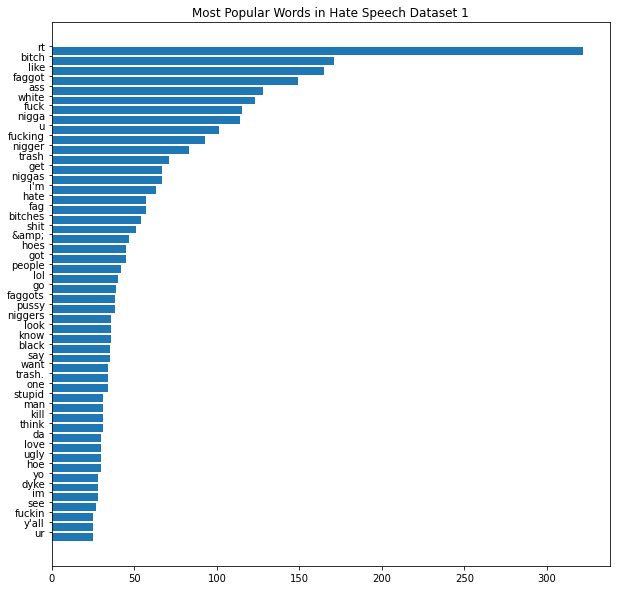

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words("english"))

def ChangeToBin_Davidson(integer):  
    """ Changes davidson dataset to binary encoding as opposed to tri-class, making offensive class part of the non-hate class
    Parameters
    ----------
    integer : int
      True labels for each of the samples in the training data
    Returns
    integer : int
      True labels in binary form
    -------
    """
  if integer == 0:
    integer = 1
  else:
    integer = 0
  return integer

def remove_stopwords(text): # removes stopwords from a given input text
    """ Removes Stopwords from an input string
    Parameters
    ----------
    text : string
      String containing stopwords
    Returns
    text : string
      String without stopwords
    -------
    """
  text = [word.lower() for word in text.split() if word.lower() not in stop]

  return " ".join(text)




titles_table = pd.read_csv("labeled_data.csv")


titles_table["label"] = titles_table["class"].apply(ChangeToBin_Davidson)


hate_speech_test = titles_table[titles_table.label.eq(1)]



hate_speech_test = hate_speech_test.drop(['index', 'count', 'hate_speech', 'offensive_language', 'neither','class'], axis = 1)
plt.figure(figsize=(10,10))

wordBarGraphFunction(hate_speech_test,'tweet',"Most Popular Words in Hate Speech Dataset 1")

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)


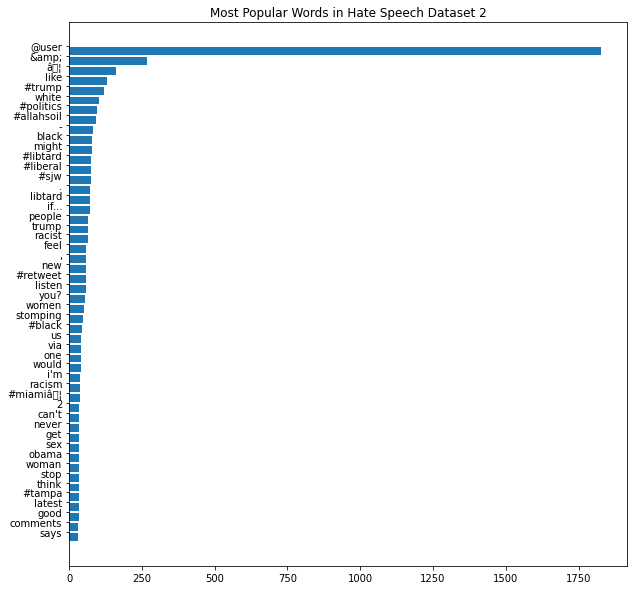

In [ ]:
titles_table = pd.read_csv("train_tweet.csv")

titles_table = titles_table[titles_table.label.eq(1)]

plt.figure(figsize=(10,10))
wordBarGraphFunction(titles_table,'tweet',"Most Popular Words in Hate Speech Dataset 2")

# Building ML Model


In [ ]:
!pip install ktrain #installs ktrain package


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
import os #allows use of GPU for ktrain
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [ ]:
#Initializes configuration variables

datasetType = 1
lemmatize = 1
class_weights = 1
remove_URL_User =1

In [ ]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


def Clean_Text(text):
    """ Removes Stopwords from an input string
    Parameters
    ----------
    text : string
      Input Tweet
    Returns
    text : string
      Preprocessed Tweet
    -------
    """
    text = str(text)
    text = re.sub(r'"','', text)
    text = re.sub(r'&amp','', text)
    text = re.sub(r'RT[\s]+','', text) # removes rt's


    if remove_URL_User == 1:
      text = re.sub(r'@[A-Za-z0-9_]+','', text)#Remove's @'s
      text = re.sub(r'http?:\/\/\S+', '', text)# removes hyperlinks
      text = re.sub(r'https?:\/\/\S+', '', text)# removes hyperlinks
    elif remove_URL_User == 2:
      text = re.sub(r'@[A-Za-z0-9_]+','@USER', text)#substitutes @'s
      text = re.sub(r'http?:\/\/\S+', 'HTTPURL', text)# substitutes hyperlinks
      text = re.sub(r'https?:\/\/\S+', 'HTTPURL', text)# substitutes hyperlinks


    text = re.sub(r'[&8216;]+','',text)#removes apostrophes that are miscoded
    text = re.sub(r'[&8217;]+','',text)#removes apostrophes that are miscoded
    text = re.sub(r'[\n]+','',text)#removes \n's
    text = re.sub(r'[0-9]+','',text)#removes all integers
    text = re.sub(r'[!]+','',text)# removes more than 1 exclamation point
    text = re.sub(r':','',text) # removes colons
    text = re.sub(r',',' ',text) # removes commas
    text = re.sub(r'[.]+',' ',text)# removes more than 1 full stop
    text = " ".join(word.strip() for word in re.split('#|_', text)) # converts hashtags into base words
    text = text.lower()
    if lemmatize == 2:
      lemmatizer = WordNetLemmatizer()
      text = lemmatizer.lemmatize(text)
    return text


def ChangeToBin_Davidson(integer):
    """ Changes davidson dataset to binary encoding as opposed to tri-class, making offensive class part of the non-hate class
    Parameters
    ----------
    integer : int
      True labels for each of the samples in the training data
    Returns
    integer : int
      True labels in binary form
    -------
    """
  if integer == 0:
    integer = 1
  else:
    integer = 0
  return integer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import tensorflow as tf
import copy

from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words("english"))

def remove_stopwords(text): # removes stopwords
    """ Removes Stopwords from an input string
    Parameters
    ----------
    text : string
      String containing stopwords
    Returns
    text : string
      String without stopwords
    -------
    """
  text = [word.lower() for word in text.split() if word.lower() not in stop]

  return " ".join(text)


df_train = pd.read_csv("train_tweet.csv") # reads in the datasets
df_test = pd.read_csv("labeled_data.csv")



df_train['text'] = df_train['tweet'].apply(Clean_Text) # preprocesses the data


df_train = df_train.drop(["id", "tweet"], axis = 1) # removes unneccessary columns



df_test['text'] = df_test['tweet'].apply(Clean_Text)# preprocesses the data
df_test["label"] = df_test["class"].apply(ChangeToBin_Davidson)



df_test = df_test.drop(['index', 'count', 'hate_speech', 'offensive_language', 'neither','class', 'tweet'], axis = 1) # removes unneccessary columns

#negative -no hate speech. positive - hate speech
dataset = []
dataset = pd.concat([df_test, df_train], ignore_index = True) # fully combines bothh datasets


from sklearn.utils import class_weight # determines class weights from fully combined datasets
from collections import Counter
ctr = Counter(dataset['label'].values)
y = dataset['label'].values
cws = class_weight.compute_class_weight('balanced', classes = np.unique(y), y = y)
cws = dict(enumerate(cws))
train_set = []
test_set = []

if datasetType== 1: # datasets are created with a 90:10 split
  dataset['label'] = dataset['label'].apply(lambda x: 'neg' if x == 0 else 'pos')
  dataset = pd.concat([dataset, dataset.label.astype('str').str.get_dummies()], axis=1, sort=False)
  #negative -no hate speech. positive - hate speech
  dataset = dataset[['text', 'neg', 'pos']]
  train_set = dataset.sample(frac = 0.9, random_state = 200)
  test_set = dataset.drop(train_set.index)


if datasetType ==2 : # creates equivalently sized training dataset
  hate_speech_test = df_test[df_test.label.eq(1)]
  non_hate_speech_test = df_test[df_test.label.eq(0)]
  hate_speech_train = df_train[df_train.label.eq(1)]
  non_hate_speech_train = df_train[df_train.label.eq(0)]

  equal_non_hate_speech_train = non_hate_speech_train.sample(len(hate_speech_train))
  frames = [hate_speech_train,equal_non_hate_speech_train]

  
  train_set = pd.concat(frames)
  frames = [hate_speech_test, non_hate_speech_test]
  test_set = pd.concat(frames)

  train_set['label'] = train_set['label'].apply(lambda x: 'neg' if x == 0 else 'pos') # one hot encodes the data
  train_set = pd.concat([train_set, train_set.label.astype('str').str.get_dummies()], axis=1, sort=False)
  #negative -no hate speech. positive - hate speech
  train_set = train_set[['text', 'neg', 'pos']]
  train_set.head()

  test_set['label'] = test_set['label'].apply(lambda x: 'neg' if x == 0 else 'pos')# one hot encodes the data
  test_set = pd.concat([test_set, test_set.label.astype('str').str.get_dummies()], axis=1, sort=False)
  #negative -no hate speech. positive - hate speech
  test_set = test_set[['text', 'neg', 'pos']]
  test_set.head()




x_train = train_set["text"].values.tolist()
x_test = test_set["text"].values.tolist()
y_train = train_set[["neg", "pos"]].values.tolist()
y_test = test_set[["neg", "pos"]].values.tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
(x_train, y_train), (x_test, y_test), preproc = (0,0), (0,0), 0
# creates dataset objects required by ktrain
if datasetType != 1:
  (x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_set, 
                                                                    'text', # name of column containing review tweet
                                                                    label_columns=['neg', 'pos'],
                                                                    maxlen=280, 
                                                                    val_df = test_set,
                                                                    max_features=100000,
                                                                    preprocess_mode='standard',
                                                                    val_pct=0.0,
                                                                    ngram_range=1)# only 1 for bigru model
else:
  (x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(dataset, 
                                                                   'text', # name of column containing review tweet
                                                                   label_columns=['neg', 'pos'],
                                                                   maxlen=280, 
                                                                   max_features=100000,
                                                                   preprocess_mode='standard',
                                                                   val_pct=0.1,
                                                                   ngram_range=1)# only 1 for bigru model



['neg', 'pos']
       neg  pos
11551    1    0
13045    1    0
32238    1    0
2348     0    1
24456    1    0
['neg', 'pos']
       neg  pos
14061    1    0
53393    1    0
46739    0    1
18271    1    0
49084    1    0
language: en
Word Counts: 52244
Nrows: 51070
51070 train sequences
train sequence lengths:
	mean : 13
	95percentile : 24
	99percentile : 27
x_train shape: (51070,280)
y_train shape: (51070, 2)
Is Multi-Label? False
5675 test sequences
test sequence lengths:
	mean : 13
	95percentile : 24
	99percentile : 27
x_test shape: (5675,280)
y_test shape: (5675, 2)


In [ ]:
model = text.text_classifier('bigru', (x_train, y_train) , preproc=preproc) # instantiates a model with the dataset
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

#### FOR BERT AND DISTILBERT

# import ktrain
# from ktrain import text
# MODEL_NAME = 'distilbert-base-uncased'
# t = text.Transformer(MODEL_NAME, maxlen=280, class_names=['neg', 'pos'])
# trn = t.preprocess_train(x_train, y_train)
# val = t.preprocess_test(x_test, y_test)
# model = t.get_classifier()
# learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)


Is Multi-Label? False
compiling word ID features...
maxlen is 280
word vectors will be loaded from: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
processing pretrained word vectors...
loading pretrained word vectors...this may take a few moments...


done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
1596/1596 [==============================] - 472s 293ms/step - loss: 3.2302 - accuracy: 0.7814


done.
Visually inspect loss plot and select learning rate associated with falling loss


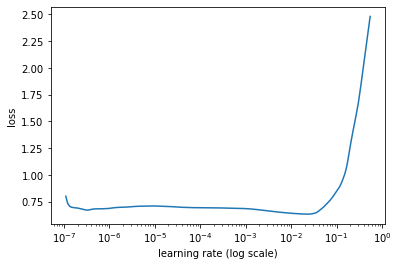

In [ ]:
#with tf.device(device_name):

if class_weights == 1:
  learner.lr_find(show_plot=True ) # used to find the optimal learning rate.
if class_weights == 2:
  learner.lr_find(show_plot=True, class_weight = cws )# used to find the optimal learning rate.

In [ ]:
if class_weights == 1:
  learner.autofit(0.002,1) # used to train model with a triangular learning rate policy and no of epochs
if class_weights == 2:
  learner.autofit(0.002,1, class_weight = cws)# used to train model with a triangular learning rate policy and no of epochs



begin training using triangular learning rate policy with max lr of 0.002...
1596/1596 [==============================] - 57s 35ms/step - loss: 0.4021 - accuracy: 0.9636 - val_loss: 0.1318 - val_accuracy: 0.9568


In [ ]:
cm = learner.validate(print_report= True) # tests the model on a given validation set

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5324
           1       0.75      0.45      0.56       351

    accuracy                           0.96      5675
   macro avg       0.86      0.72      0.77      5675
weighted avg       0.95      0.96      0.95      5675



In [ ]:
learner.view_top_losses(n=5, preproc = preproc) # views top 5 losses of a model

----------
id:2852 | loss:4.99 | true:neg | pred:pos)

user so which of his ideas do you like muslim ban the wall harassing journalists biher comments mexicans as rapists
----------
id:2927 | loss:4.76 | true:neg | pred:pos)

man stop acting like faggots and go for the win user
----------
id:4622 | loss:4.53 | true:neg | pred:pos)

them squirrels are faggots b user httpurl
----------
id:3620 | loss:4.37 | true:neg | pred:pos)

user user user user user user they can see this dumbass nigger
----------
id:3649 | loss:4.33 | true:neg | pred:pos)

user user did you get your yet faggot


In [ ]:
p = ktrain.get_predictor(learner.model, preproc = preproc) #extracts the predictor with preprocessing and lets it be saved
p.save('/content/drive/MyDrive/FinalMLModels/gru')

In [ ]:
p.explain("republicans aren't the only racist in america we have racist democrats too but don't play the token negro card httpurl") # allows contribution of a phrase to be explained

In [ ]:
!zip -r /content/drive/MyDrive/FinalMLModels/gru.zip /content/drive/MyDrive/FinalMLModels/gru #zips the model

  adding: content/hate_speech_ktrain/ (stored 0%)
  adding: content/hate_speech_ktrain/tf_model.preproc (deflated 52%)
  adding: content/hate_speech_ktrain/tf_model.h5 (deflated 15%)


# Twitter Querying


In [ ]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.1 MB/s 
     |████████████████████████████████| 22.3 MB 52.3 MB/s 
     |████████████████████████████████| 981 kB 55.8 MB/s 
     |████████████████████████████████| 263 kB 53.3 MB/s 
     |████████████████████████████████| 2.8 MB 47.2 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
     |████████████████████████████████| 468 kB 77.7 MB/s 
     |████████████████████████████████| 880 kB 77.1 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 3.3 MB 37.9 MB/s 
     |████████████████████████████████| 596 kB 70.1 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.2-py3-none-any.whl size=25313063 sha256=cd86479d1273aa0c69738189a1f2bfe871921dd25bf1a85a87a608174264670c
  Stored in directory: /root/.cache/pip/wheels/0a/b3/dd/512a01ea0b4f31d96163518b58361bb72d3bcb916d291052e7
  C

In [ ]:
import tweepy
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import ktrain
from ktrain import text
import re
import nltk
import tensorflow as tf
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
device_name = tf.test.gpu_device_name()
print(device_name)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
/device:GPU:0


In [ ]:
ACCESS_TOKEN = '' #Access tokens for accessing Tweepy API
ACCESS_TOKEN_SECRET = ''
CONSUMER_KEY = ''
CONSUMER_SECRET = ''

In [ ]:
#Create authentication
authenticate = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
authenticate.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET) 

api = tweepy.API(authenticate, wait_on_rate_limit= True, wait_on_rate_limit_notify = True)


In [ ]:
bert2211 = ktrain.load_predictor("/content/drive/MyDrive/FinalMLModels/bert2211")
bert2212 = ktrain.load_predictor("/content/drive/MyDrive/FinalMLModels/bert2212") # load models from relative path
distilbert = ktrain.load_predictor("/content/drive/MyDrive/FinalMLModels/distilbert")
gru = ktrain.load_predictor("/content/drive/MyDrive/FinalMLModels/gru")
nbsvm = ktrain.load_predictor("/content/drive/MyDrive/FinalMLModels/nbsvm")


In [ ]:
def majority_rule(text): 
   """ Applies majority rule from ensemble of ML models
    Parameters
    ----------
    text : int
      Input Tweet
    Returns
    integer : int
      Majority rule classification for input tweet
    -------
    """
  predictions = [bert2211.predict(text), bert2212.predict(text), distilbert.predict(text), gru.predict(text), nbsvm.predict(text)]
  positives = predictions.count("pos")
  if positives >= 3:
    return 1
  else:
    return 0


In [ ]:
def Clean_Text(text):
    """ Removes Stopwords from an input string
    Parameters
    ----------
    text : string
      Input Tweet
    Returns
    text : string
      Preprocessed Tweet
    -------
    """
    text = str(text)
    text = re.sub(r'"','', text)
    text = re.sub(r'&amp','', text)
    text = re.sub(r'@[A-Za-z0-9_]+','@USER', text)#Remove's @'s
    text = re.sub(r'RT[\s]+','', text) # removes rt's
    text = re.sub(r'http?:\/\/\S+', 'HTTPURL', text)# removes hyperlinks
    text = re.sub(r'https?:\/\/\S+', 'HTTPURL', text)# removes hyperlinks
    text = re.sub(r'[&8216;]+','',text)#removes apostrophes that are miscoded
    text = re.sub(r'[&8217;]+','',text)#removes apostrophes that are miscoded
    text = re.sub(r'[\n]+','',text)#removes \n's
    text = re.sub(r'[0-9]+','',text)#removes all integers
    text = re.sub(r'[!]+','',text)
    text = re.sub(r':','',text)
    text = re.sub(r',',' ',text)
    text = re.sub(r'[.]+',' ',text)
    text = re.sub(r' +', ' ', text)
    text = " ".join(word.strip() for word in re.split('#|_', text))
    text = text.lower()
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text)
    return text

In [ ]:
def tenTweets_to_Hate_User(tweets):
    """ Classifies whether a user is hateful
    Parameters
    ----------
    tweets : List[string]
      Ten input tweets
    Returns
    label : int
      Classification if user is a hate user or not based on threshold
    -------
    """
  y_pred = 0
  for j in tweets:
    j = Clean_Text(j)
    y_pred+= majority_rule(j)
  if y_pred>= 7: # 7 is the defined threshold
    return 1
  else:
    return 0

In [ ]:
import random

word_list = ["bitch", "faggot", "ass", "white", "fuck", "nigga", "fucking", "nigger", "trash", "niggas", "hate", "bitch", "bitches"] # define word list

user_names = []
while len(user_names)== 0 or len(word_list) == 0 : # query random word from word list till users are found
  query_word = random.choice(word_list)
  word_list.remove(query_word)
  query = api.search(query_word, lang = "en")

  columns = ['User', 'Tweet']
  data = []

  for tweet in query:
    data.append([tweet.user.screen_name, tweet.text])

  df_query = pd.DataFrame(data , columns = columns)
  df_query['text'] = df_query['Tweet'].apply(Clean_Text) # clean dataframe 
  y_pred = []

  for i, val in enumerate(df_query['text']):
    y_pred.append(majority_rule(val))# classifies tweet

  user_names = []

  for i, val in enumerate(y_pred):
    if val == 1:
      user_names.append(df_query["User"][i])





In [ ]:
print(user_names)

['wxllflxwrrr', 'iyeezyy', 'RodDisneyFan', 'CoreyTanner', 'richard40163651', 'ShesChey_', 'nanaaaa16083129', 'osheblows', 'kynxdoll']


In [ ]:
hate_users = [] #classifies last ten tweets
for i in user_names:
    lastTenTweets = api.user_timeline(user_id = i, count = 10);
    tentweetstext = []
    for tweet in lastTenTweets:
      tentweetstext.append(tweet.text)
    result = tenTweets_to_Hate_User(tentweetstext)
    if result == 1:
      hate_users.append(i)


In [ ]:
print(hate_users)

['jasoncaptaindr1', 'NnaKeKagiso', 'ASLTWOutbreak', 'Lotus_flower122', 'AlphalumaO', 'AlphalumaO', 'AlphalumaO', 'ONIKASFAVOR', 'AlphalumaO', 'iKingcoRey', 'AlphalumaO', 'DrHeureke182', 'roideus_', 'Yeddz3']


In [ ]:
user_count = 10 # define how many friends and followers can be queried

def get_hate_user_stats_screen_name(hate_users):
      """ Returns hate user statistics(friends and followers) from a given hate user up to user_count
    Parameters
    ----------
    hate_users : List[string]
      Input list of users classified to be hate users
    Returns
    hate_user_stats : List[[string, List[int], List[int]]]
      Returns the input list of hate users with lists of followers and friends up to user_count
    -------
    """
  hate_user_stats = []
  for user in hate_users:
    try:
      hate_user_followers = api.followers_ids(screen_name = user, count = user_count)
      hate_user_friends = api.friends_ids(screen_name = user, count = user_count)
      hate_user_stats.append([user, hate_user_followers, hate_user_friends])
    except tweepy.TweepError:
      continue
  return hate_user_stats
def get_hate_user_stats_user_id(hate_users):
    """ Returns hate user statistics(friends and followers) from a given hate user id up to user_count
    Parameters
    ----------
    hate_users : List[int]
      Input list of user ids classified to be hate users
    Returns
    hate_user_stats : List[[int, List[int], List[int]]]
      Returns the input list of hate user ids with lists of followers and friends up to user_count
    -------
    """
  hate_user_stats = []
  for user in hate_users:
    try:
      hate_user_followers = api.followers_ids(user_id = user, count = user_count)
      hate_user_friends = api.friends_ids(user_id = user, count = user_count)
      hate_user_stats.append([user, hate_user_followers, hate_user_friends])
    except tweepy.TweepError:
      continue
  return hate_user_stats

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
depth = 3 # defines depth of graph(how deep the network can go in terms of friends and followers)
G = nx.MultiDiGraph()
red_edges = []
red_nodes = []
hate_user_stats = get_hate_user_stats_screen_name(hate_users) # gets hate user's friends and followers
with tf.device(device_name):

  for z in range(1 , depth):
    new_hate_users = []
    for i in hate_user_stats:
      prim_user = i[0]
      red_nodes.append(prim_user)
      hate_user_friends = i[1]
      hate_user_followers = i[2]
      print(prim_user)
      for j in hate_user_friends:
        G.add_edge(prim_user, j)
        try:
          lastTenTweets = api.user_timeline(user_id = j, count = 10); # 
          y_pred = 0
          for k in lastTenTweets:
            k = Clean_Text(k.text)
            y_pred += majority_rule(k)
          if y_pred >= 7:
            new_hate_users.append(j)
            red_edges.append((prim_user, j))
            red_nodes.append(j)
        except tweepy.TweepError:
          continue

      for j in hate_user_followers:
        G.add_edge(j, prim_user)
        try:
          lastTenTweets = api.user_timeline(user_id = j, count = 10);
          y_pred = 0
          for k in lastTenTweets:
            k = Clean_Text(k.text)
            y_pred+= majority_rule(k)
          if y_pred >= 7:
            new_hate_users.append(j)
            red_edges.append((j, prim_user))
            red_nodes.append(j)
        except tweepy.TweepError:
          continue

    new_hate_users = list(set(new_hate_users))
    print(new_hate_users)
    hate_user_stats = get_hate_user_stats_user_id(new_hate_users)


[]
[]
[]


Network:


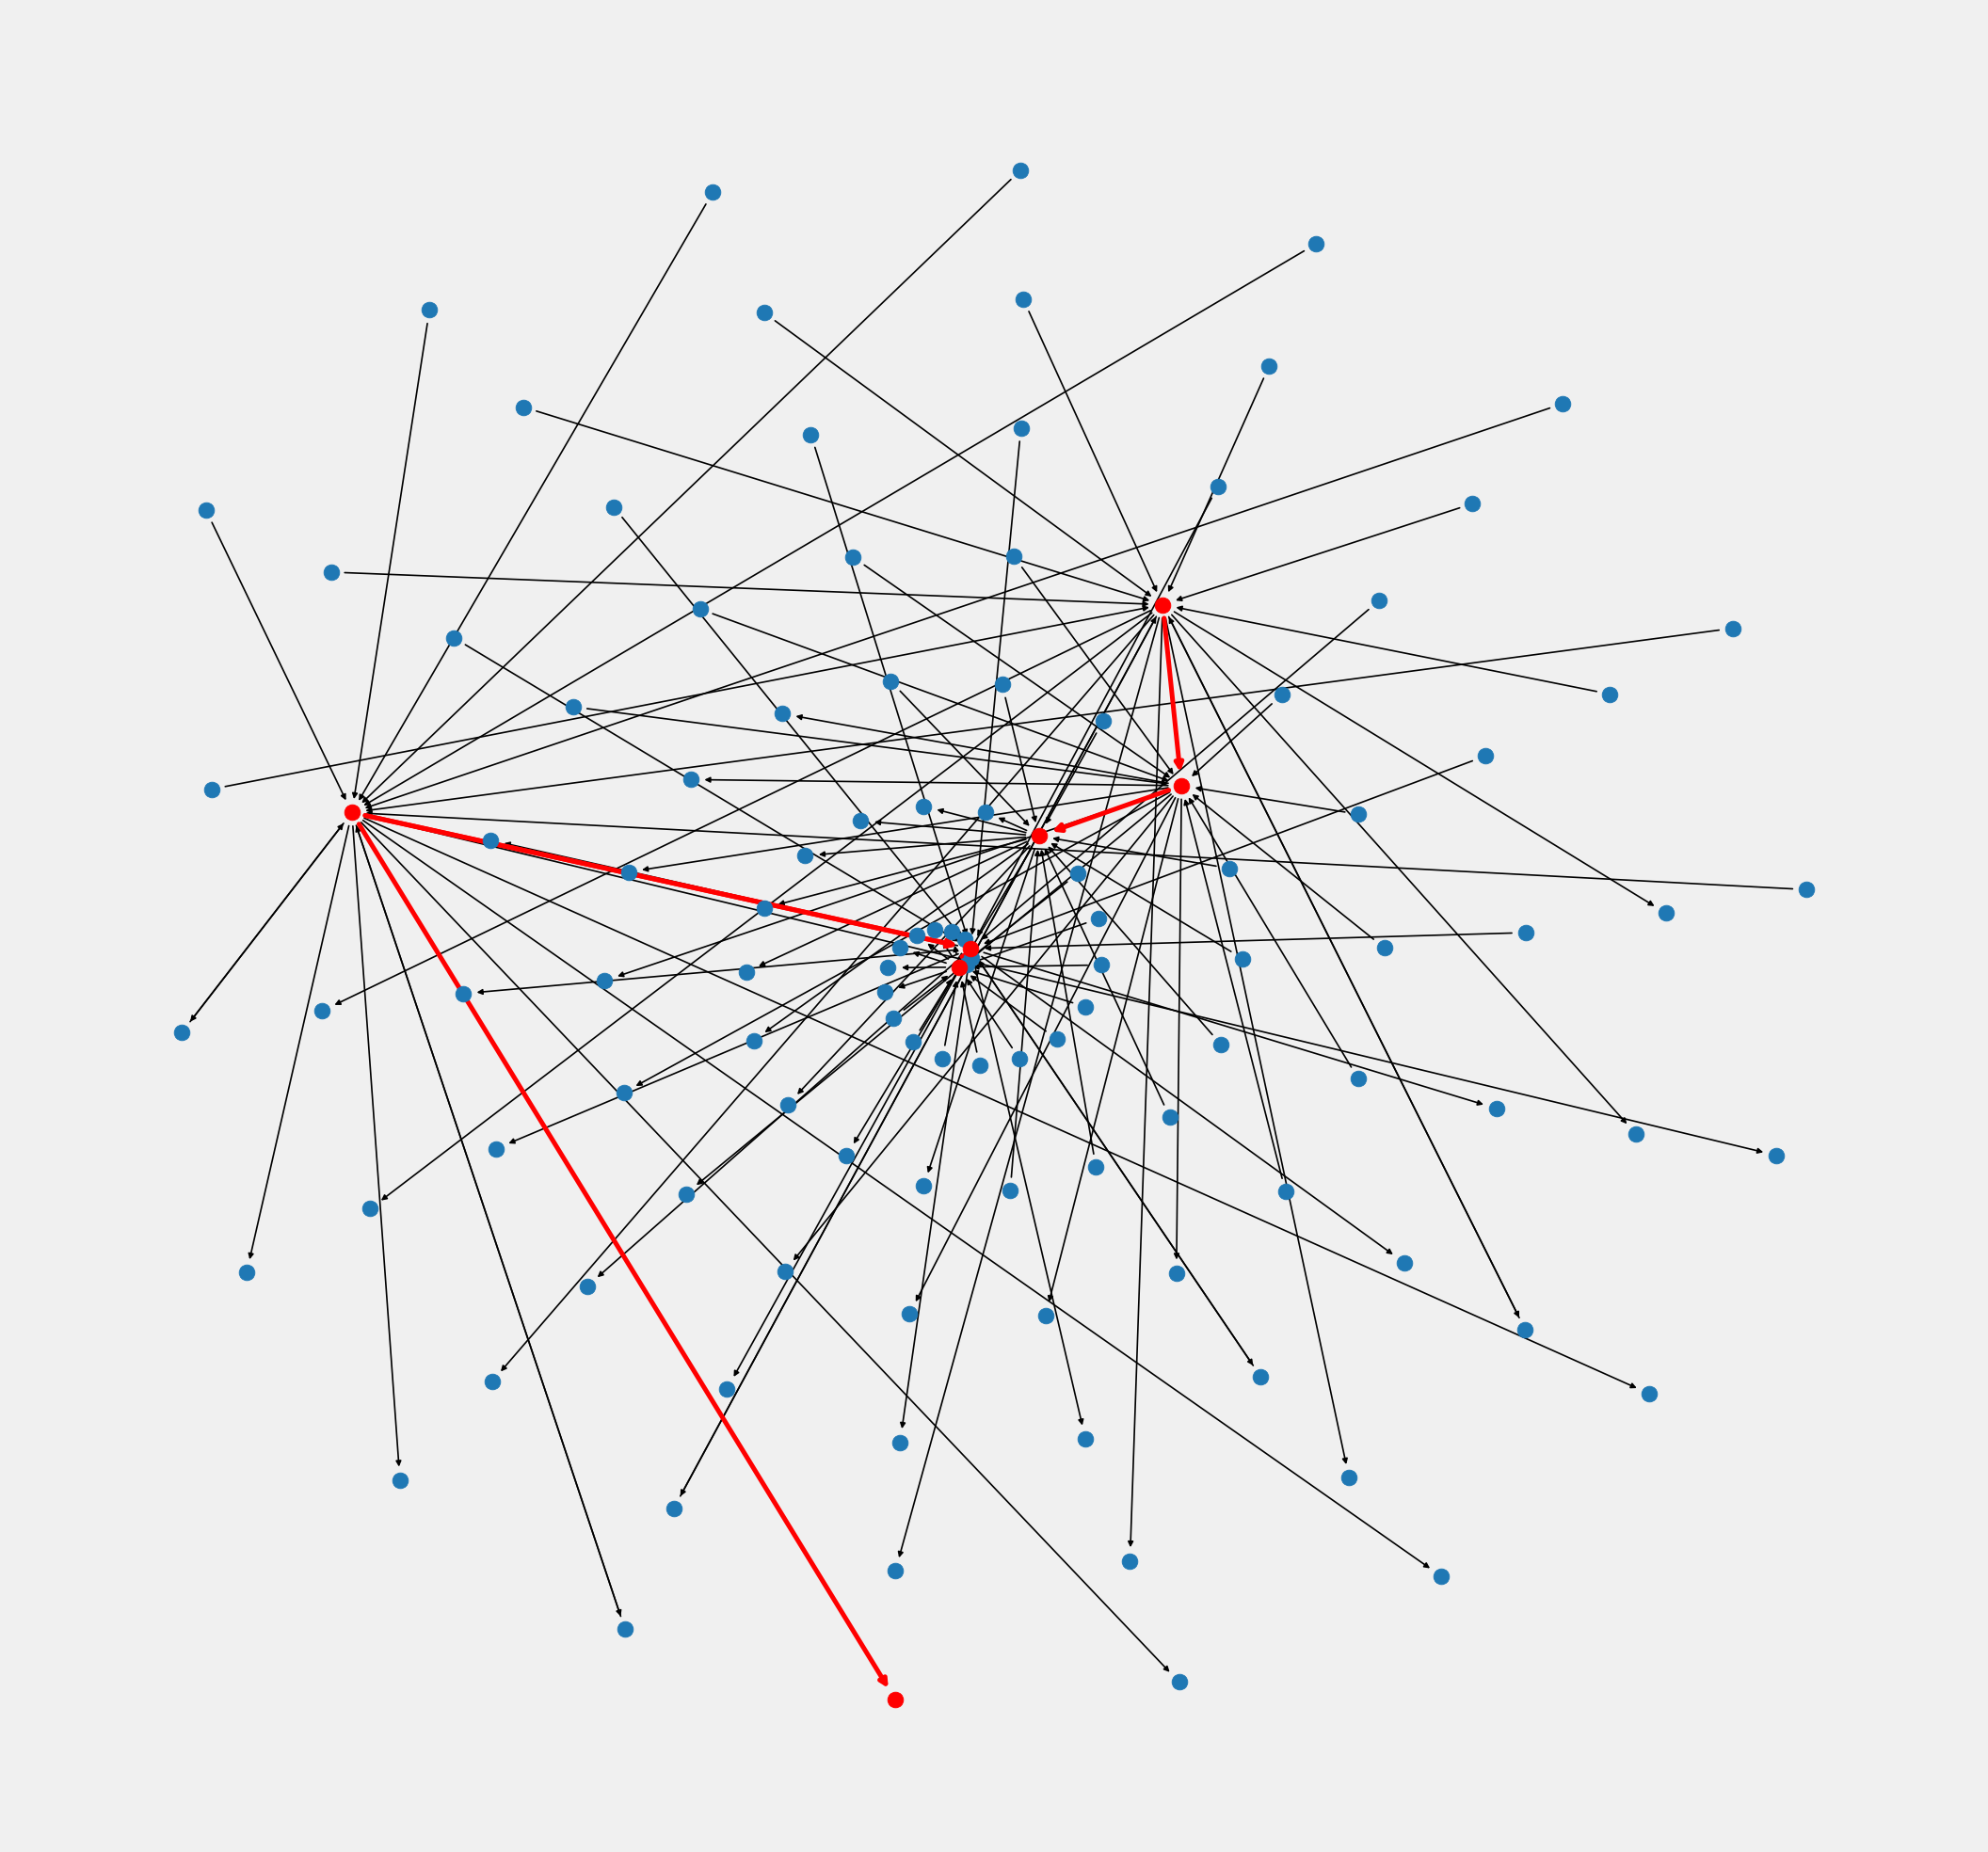

In [ ]:
# draws network with correct colouring
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in G.edges()]
black_edges = [edge for edge in G.edges() if edge not in red_edges]

def_nodes =[node for node in G.nodes() if node not in red_nodes]

red_nodes = list(set(red_nodes))
fig, ax = plt.subplots(1 , 1 , figsize = (20,20), dpi = 120)
ax.grid(False)
pos = nx.spiral_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist = def_nodes, cmap=plt.get_cmap('jet'), node_size = 100, ax = ax)
nx.draw_networkx_nodes(G, pos, nodelist = red_nodes, cmap=plt.get_cmap('jet'), node_size = 100, ax = ax, node_color = 'r')


nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=True, ax = ax, arrowsize = 7)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True, ax = ax, arrowsize = 10, width = 3)


#Testing Area


In [ ]:
def changetoBinhateCheck(text):
  if text == "hateful":
    return 1
  else:
    return 0

In [ ]:
test_df = pd.read_csv("test_suite_cases.csv")


test_df["label_gold"] = test_df["label_gold"].apply(changetoBinhateCheck)

In [ ]:
test_df

,Unnamed: 0,functionality,case_id,test_case,label_gold,target_ident,direction,focus_words,focus_lemma,ref_case_id,ref_templ_id,templ_id,case_templ
0,0,derog_neg_emote_h,1,I hate women.,1,women,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
1,1,derog_neg_emote_h,2,I hate trans people.,1,trans people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
2,2,derog_neg_emote_h,3,I hate gay people.,1,gay people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
3,3,derog_neg_emote_h,4,I hate black people.,1,black people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
4,4,derog_neg_emote_h,5,I hate disabled people.,1,disabled people,general,hate,hate,NaN,NaN,1,I hate [IDENTITY_P].
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,3723,spell_leet_h,3897,Gay people are all complete 4ssholes.,1,gay people,general,4ssholes,asshole,1232.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.
3724,3724,spell_leet_h,3898,Black people are all complete 4ssholes.,1,black people,general,4ssholes,asshole,1233.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.
3725,3725,spell_leet_h,3899,Disabled people are all complete 4ssholes.,1,disabled people,general,4ssholes,asshole,1234.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.
3726,3726,spell_leet_h,3900,Muslims are all complete 4ssholes.,1,Muslims,general,4ssholes,asshole,1235.0,256.0,866,[IDENTITY_P] are all complete 4ssholes.


In [ ]:
tp = 0
tn = 0
fp = 0
fn = 0



for i, val in enumerate(test_df["test_case"]):
  result = majority_rule(val)
  print(i)
  if result == 1:
    if test_df["label_gold"][i] == 1:
      tp +=1
    else:
      fp +=1
  else:
    if test_df["label_gold"][i] == 0:
      tn +=1
    else:
      fn+=1

In [ ]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 2239
True Negatives: 302
False Positives: 863
False Negatives: 324


In [ ]:
print("Hate Speech Accuracy: ", tp/(tp+fn))
print("Non-Hate Speech Accuracy: ", tn/(tn+fp))
print("Total Accuracy: ", (tp+tn)/(tp+tn+fn+fp))

Hate Speech Accuracy:  0.8735856418259852
Non-Hate Speech Accuracy:  0.2592274678111588
Total Accuracy:  0.681598712446352
